In [47]:
import numpy as np
from numpy.linalg import norm
from scipy.linalg import eigh, inv

DTYPE = np.longdouble
'''
def f(x):
    return x[0]**4 + x[1]**4 + x[2]**4 - x[0]**3*x[2] - 12*x[0]*x[2]**2 + x[0]*x[1]*x[2] - \
           3*x[1]**3 - 4*x[0]*x[1] + x[3]**2 + 9*x[1] - 3*x[3] + 4
  
def gradf(x):
    return np.array([
        4*x[0]**3 - 3*x[0]**2*x[2] - 12*x[2]**2 + x[1]*x[2] - 4*x[1],
        4*x[1]**3 + x[0]*x[2] - 9*x[1]**2 - 4*x[0] + 9,
        4*x[2]**3 - x[0]**3 - 24*x[0]*x[2] + x[0]*x[1],
        2*x[3] - 3], dtype=DTYPE)

def hessf(x):
    return np.array([
    [12*x[0]**2-6*x[0]*x[1],  x[2]-4,             -3*x[0]**2-24*x[2]+x[1], 0],
    [x[2]-4,                  12*x[1]**2-18*x[1], x[0],                    0],
    [-3*x[0]**2-24*x[2]+x[1], x[0],               12*x[2]**2-24*x[0],      0],
    [0,                       0,                  0,                       2]], dtype=DTYPE)
'''

def multiVariableHalfOpen(f, x, d, T):
    '''
    INPUT
        f: multivariable function to minimise
        x: starting point
        d: direction vector
        T: upper bound increment parameter
    OUTPUT
        a: lower bound on the location of minimum of f in direction d from x
        b: upper bound on the location of minimum of f in direction d from x
    '''
    k = 1
 
    p = x
    q = x + T*d

    fp = f(p)
    fq = f(q)

    
    while fp > fq:
        k += 1
        p = q
        fp = fq
        q = p + (2**(k-1))*T*d
        fq = f(q)
            
    if k == 1:
        a = 0
        b = T

    elif k == 2:
        a = 0
        b = 3*T

    else:
        u = np.arange(0,k,1)
        v = np.arange(0,k-2,1)

        a = T*sum((2*np.ones(k-2))**v)       
        b = T*sum((2*np.ones(k))**u) 
        
    return a, b

def multiVariableGoldenSectionSearch(f, a, b, tolerance, x, d):
    '''
    performs golden section search for finding minimum of f along the
    direction d, starting at x, where the minimum has upper and lower bound [a, b]
    '''
    if b <= a:
        raise ValueError('b must be strictly greater than a')
    if tolerance <= 0:
        raise ValueError('tolerance must be strictly positive')

    # Begin the Golden Search algorithm

    gamma = (np.sqrt(5) - 1)/2 
    k = 1

    p = b - gamma*(b-a)
    q = a + gamma*(b-a)

    fp = f(x + p*d)
    fq = f(x + q*d)

    while b-a >= 2*tolerance:
        k += 1

        if fp <= fq:
            b = q
            q = p
            fq = fp
            p = b - gamma*(b-a)
            fp = f(x + p*d)

        else:
            a = p
            p = q
            fp = fq
            q = a + gamma*(b-a)
            fq = f(x + q*d)

    # Midpoint of the final interval
    minEstimate = (a+b)/2
    fminEstimate = f(x + minEstimate*d)  
    return minEstimate, fminEstimate

def BFGS(f, gradf, x0, tolerance1, tolerance2, T, H0, **kwargs):
    '''
    INPUT
        f:          the multivariable function to minimise
        gradf:      function which returns the gradient vector of f evaluated at x
        x0:         the starting iterate
        tolerance1: tolerance for stopping criterion of steepest descent method
        tolerance2: tolerance for stopping criterion of line minimisation
        T:          parameter used by the "improved algorithm for finding an upper bound for the minimum" along 
                    each given descent direction
    OUTPUT
        xminEstimate: estimate of the minimum
        fminEstimate: the value of f at xminEstimate
        k:            iteration counter
    '''
    k = 0
    iteration_number = 0

    xk = np.copy(x0)
    xk_old = np.copy(x0)
    H_old = H0
    
    while norm(gradf(xk)) >= tolerance1:
        iteration_number += 1  
        
        # Correction if det H_old gets too large or small
        H_old /= np.amax(H_old) 

        # Get dk as a row vector
        dk = -H_old.dot(gradf(xk))
        # minimise f with respect to t in the direction dk

        # (1) find upper and lower bound, [a,b], for the stepsize t
        a, b = multiVariableHalfOpen(f, xk, dk, T)

        # (2) use golden section algorithm to estimate the stepsize t in [a,b] which minimises f in the direction dk from xk
        tmin, fmin = multiVariableGoldenSectionSearch(f, a, b, tolerance2, xk, dk)

        k += 1

        xk += tmin*dk
        xk_new = xk_old +tmin*dk
        
        sk=(xk_new - xk_old).T
        gk= (gradf(xk_new)-gradf(xk_old)).T
        rk=(H_old.dot(gk))/(sk.dot(gk))
        
        H_new = H_old + (1 + rk.dot(gk))/(sk.dot(gk))*np.outer(sk, sk) - np.outer(sk, rk) - np.outer(rk, sk)
        
        xk_old = xk_new
        H_old = H_new

    xminEstimate = xk
    fminEstimate = f(xminEstimate)
    return xminEstimate, fminEstimate, k

def NewtonMethod(f, gradf, x0, tolerance1, tolerance2, T, hessf, **kwargs):
    '''
    INPUT
        f:          the multivariable function to minimise
        gradf:      function which returns the gradient vector of f evaluated at x 
        x0:         the starting iterate
        tolerance1: tolerance for stopping criterion of steepest descent method
        tolerance2: tolerance for stopping criterion of line minimisation
        T:          parameter used by the "improved algorithm for finding an upper bound for the minimum" along 
                    each given descent direction
    OUTPUT
        xminEstimate: estimate of the minimum
        fminEstimate: the value of f at xminEstimate
        k:            iteration counter
    '''
    k = 0
    xk = x0
    while norm(gradf(xk)) >= tolerance1:
        gradf(xk)
        Hessian = hessf(xk)
        
        # the following seemed to break the algorithm, so its gone now
        '''
        # Correction if det Hessian gets too large or small
        Hessian /= np.amax(Hessian) 
        '''

        # Checks to see if the Hessian is positive definite
        if np.all(eigh(Hessian, eigvals_only=True) > 0):
            # the Newton direction - as a row vector
            dk = -(inv(Hessian).dot(gradf(xk).T)).T
        else:
            # the steepest descent direction.
            dk = -gradf(xk)
                   
        # Minimise f with respect to t in the direction dk
                   
        # (1) find upper and lower bound,[a,b],for the stepsize t 
        a, b = multiVariableHalfOpen(f, xk, dk, T)
        
        # (2) use golden section algorithm to estimate the stepsize t in [a,b] which minimises f in the direction dk from xk
        tmin, fmin = multiVariableGoldenSectionSearch(f, a, b, tolerance2, xk, dk)
                   
        k += 1
        xk += tmin*dk
                   
    xminEstimate = xk
    fminEstimate = f(xminEstimate)
    return xminEstimate, fminEstimate, k

def steepestDescentMethod(f, gradf, x0, tolerance1, tolerance2, T, **kwargs):
    '''
    INPUT
        f:          the multivariable function to minimise
        gradf:      function which returns the gradient vector of f evaluated at x 
        x0:         the starting iterate
        tolerance1: tolerance for stopping criterion of steepest descent method
        tolerance2: tolerance for stopping criterion of line minimisation
        T:          parameter used by the "improved algorithm for finding an upper bound for the minimum" along 
                    each given descent direction
    OUTPUT
        xminEstimate: estimate of the minimum
        fminEstimate: the value of f at xminEstimate
        k:            iteration counter
    '''
    k = 0
    xk = x0
    
    while norm(gradf(xk)) >= tolerance1:
        # Steepest descent direction
        dk = -gradf(xk)
        
        # Minimise f with respect to t in the direction dk
        
        # (1) find upper and lower bound, [a,b], for the stepsize t
        a, b = multiVariableHalfOpen(f, xk, dk, T)

        # (2) use golden section algorithm  to estimate the stepsize t in [a,b] which minimises f in the direction dk from xk
        tmin, fmin = multiVariableGoldenSectionSearch(f, a, b, tolerance2, xk, dk)

        k += 1
        xk += tmin*dk
        
    xminEstimate = xk
    fminEstimate = f(xminEstimate)
    return xminEstimate, fminEstimate, k

In [54]:
steepestDescentMethod(f, gradf, np.array([1.0, 2,3,4], dtype=DTYPE), 10**(-2), 10**(-5), 10)

(array([nan, nan, nan, nan], dtype=float128), nan, 590)

In [52]:
NewtonMethod(f, gradf, np.array([1,2,3,4], dtype=DTYPE), 10**(-2), 10**(-5), 10, hessf)

(array([ 1.04125133e-03, -2.28569019e-02,  2.61698880e-01,  3.94403257e+00],
       dtype=float128),
 2455.1920484765337616,
 306)

In [53]:
BFGS(f, gradf, np.array([1.0, 2,3,4]), 10**(-2), 10**(-5), 10, np.eye(4))

(array([ 1.04125134e-03, -2.28569023e-02,  2.61698891e-01,  3.94403255e+00]),
 2455.19204847153,
 12)

In [300]:
from itertools import product
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from time import time

N_DIMENSIONS = 4
ALGORITHMS = {steepestDescentMethod: 'steepestDescentMethod', NewtonMethod: 'NewtonMethod', BFGS: 'BFGS'}

def experiment(algorithms, x_range, tolerance1s, tolerance2s, Ts, trials):
    '''
    Can provide list of descent algorithms, tolerances (for descent and stepsize), Ts and will try every combination.
    Each combination is trialled 'trials' number of times, and points are chosen from x_range (x_min, x_max) in Rn space 
    Returns results in a pandas dataframe
    '''
    columns = ['algorithm', 'tolerance1', 'tolerance2', 'T', 'x0', 'xmin', 'fmin', 'iterations', 'time']
    results = {column: [] for column in columns}
    
    for algorithm, tolerance1, tolerance2, T in tqdm(list(product(algorithms, tolerance1s, tolerance2s, Ts))*trials):
        # Choose a random point in the x_range
        x0 = np.random.rand(N_DIMENSIONS)*(x_range[1]-x_range[0]) + x_range[0]
        
        # Time run of algorithm
        start = time()
        xmin, fmin, k = algorithm(f, gradf, np.copy(x0), tolerance1, tolerance2, T, 
                                  **{'hessf': hessf, 'H0': np.eye(N_DIMENSIONS)})
        end = time()
        t = end - start

        # Record trial
        for column, result in zip(columns, [ALGORITHMS[algorithm], tolerance1, tolerance2, T, 
                                            np.round(x0, 2), np.round(xmin, 2), round(fmin, 2), k, t]):
            results[column].append(result)
            
    return pd.DataFrame(results)    

In [306]:
def plot(x, y, title='Title'):
    data = results.groupby(['algorithm', x]).mean().reset_index()
    
    # Special case for counts
    if y == 'count':
        counts = results.groupby(['algorithm', x]).count()
        index = counts.index.names
        counts = counts.reset_index()[index+['time']]
        counts.columns = index + ['count']
        data = pd.merge(left=results.groupby(['algorithm', x]).mean().reset_index(), right=counts, on=index)
    
    labels = data[x].unique()
    sdm = data[data['algorithm'] == 'steepestDescentMethod'][y]
    nm = data[data['algorithm'] == 'NewtonMethod'][y]
    bfgs = data[data['algorithm'] == 'BFGS'][y]

    fig, ax = plt.subplots(figsize=(20, 10))

    xs = np.arange(len(labels))  # the label locations
    width = 0.25  # the width of the bars

    ax.bar(xs - width, sdm,  width, label='steepestDescentMethod')
    ax.bar(xs,         nm,   width, label='NewtonMethod')
    ax.bar(xs + width, bfgs, width, label='BFGS')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    if y == 'iterations':
        ax.set_ylabel('Ave iterations per search', fontsize=28)  
    elif y == 'time':
        ax.set_ylabel('Ave time per search (sec)', fontsize=28)
    else:
        ax.set_ylabel('No. of times', fontsize=28)
        
    ax.set_xlabel(x, fontsize=28)
    ax.set_title(title, fontsize=32)
    ax.set_xticks(xs)
    ax.set_xticklabels(labels)
    ax.legend(frameon=False, fontsize=24)
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=22)
    sns.despine()
    plt.show()

# Below is all the code that can be edited to get whatever output we want

In [29]:
import numpy as np
X,Y = 0,1
DTYPE = np.longdouble

data = np.genfromtxt('traffic_data.csv', delimiter=',', skip_header=1).T


s_xi = data[X].sum()
s_yi = data[Y].sum()

s_xi0 = sum([xi**0 for xi in data[X]])
s_xi2 = sum([xi**2 for xi in data[X]])
s_xi3 = sum([xi**3 for xi in data[X]])
s_xi4 = sum([xi**4 for xi in data[X]])
s_xi5 = sum([xi**5 for xi in data[X]])
s_xi6 = sum([xi**6 for xi in data[X]])

s_yi2 = sum([yi**2 for yi in data[Y]])

s_yixi  = sum([data[Y][i]*(data[X][i]**1) for i in range(len(data[X]))])
s_yixi2 = sum([data[Y][i]*(data[X][i]**2) for i in range(len(data[X]))])
s_yixi3 = sum([data[Y][i]*(data[X][i]**3) for i in range(len(data[X]))])



def f(x):
    return  s_yi2 - 2*x[0]*s_yixi3 - 2*x[1]*s_yixi2 - 2*x[2]*s_yixi - 2*x[3]*s_yi + \
            x[0]**2 * s_xi6 + x[1]**2 * s_xi4 + x[2]**2 * s_xi2 + x[3]**2 * s_xi0 + \
            2*x[0]*x[1]*s_xi5 + 2*x[0]*x[2]*s_xi4 + 2*x[0]*x[3]*s_xi3 + \
            2*x[1]*x[2]*s_xi3 + 2*x[1]*x[3]*s_xi2 + 2*x[2]*x[3]*s_xi
  
def gradf(x):
    return np.array([
        -2*s_yixi3 + 2*x[0]*s_xi6 + 2*x[1]*s_xi5 + 2*x[2]*s_xi4 + 2*x[3]*s_xi3,
        -2*s_yixi2 + 2*x[1]*s_xi4 + 2*x[0]*s_xi5 + 2*x[2]*s_xi3 + 2*x[3]*s_xi2,
        -2*s_yixi  + 2*x[2]*s_xi2 + 2*x[0]*s_xi4 + 2*x[1]*s_xi3 + 2*x[3]*s_xi ,
        -2*s_yi    + 2*x[3]*s_xi0 + 2*x[0]*s_xi3 + 2*x[1]*s_xi2 + 2*x[2]*s_xi  ], dtype=DTYPE)

def hessf(x):
    return np.array([
    [2*s_xi6, 2*s_xi5, 2*s_xi4, 2*s_xi3],
    [2*s_xi5, 2*s_xi4, 2*s_xi3, 2*s_xi2],
    [2*s_xi4, 2*s_xi3, 2*s_xi2, 2*s_xi ],
    [2*s_xi3, 2*s_xi2, 2*s_xi , 2*s_xi0]], dtype=DTYPE)

In [310]:
%%time
# This cell will take a while to run
results = experiment([steepestDescentMethod, NewtonMethod, BFGS], [-10, 10], [10**(-2)], [10**(-5)], [10], 1000)
results.sample(5)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [08:33<00:00,  5.84it/s]

Wall time: 8min 33s


,algorithm,tolerance1,tolerance2,T,x0,xmin,fmin,iterations,time
838,NewtonMethod,0.01,0.00001,10,"[1.73, 0.16, 1.96, 5.01]","[9.48, -1.85, 9.0, 1.5]",-2316.50,15,0.009030
585,steepestDescentMethod,0.01,0.00001,10,"[8.05, -4.71, -0.26, 6.58]","[9.48, -1.85, 9.0, 1.5]",-2316.50,1140,0.666214
197,BFGS,0.01,0.00001,10,"[-1.95, 1.82, -7.03, -4.81]","[9.48, -1.85, 9.0, 1.5]",-2316.50,15,0.011038
1248,steepestDescentMethod,0.01,0.00001,10,"[-7.87, -2.47, 8.59, -0.41]","[3.04, 2.76, -4.13, 1.5]",-176.53,332,0.182604
2117,BFGS,0.01,0.00001,10,"[7.81, 7.83, 8.85, -3.88]","[9.48, -1.85, 9.0, 1.5]",-2316.50,12,0.008028


In [311]:
# Results, grouped by whatever you'd like
results.groupby(['algorithm', 'fmin']).mean().reset_index()

,algorithm,fmin,tolerance1,tolerance2,T,iterations,time
0,BFGS,-2316.50,0.01,0.00001,10.0,11.679245,0.008207
1,BFGS,-176.53,0.01,0.00001,10.0,10.797826,0.007655
2,BFGS,-6.34,0.01,0.00001,10.0,9.555556,0.006888
3,NewtonMethod,-2316.50,0.01,0.00001,10.0,18.554386,0.013835
4,NewtonMethod,-176.53,0.01,0.00001,10.0,26.462209,0.019577
5,NewtonMethod,-6.34,0.01,0.00001,10.0,8.430233,0.006329
6,steepestDescentMethod,-2316.50,0.01,0.00001,10.0,1366.132632,0.815276
7,steepestDescentMethod,-176.53,0.01,0.00001,10.0,352.076923,0.209522
8,steepestDescentMethod,-6.34,0.01,0.00001,10.0,42.409091,0.025494


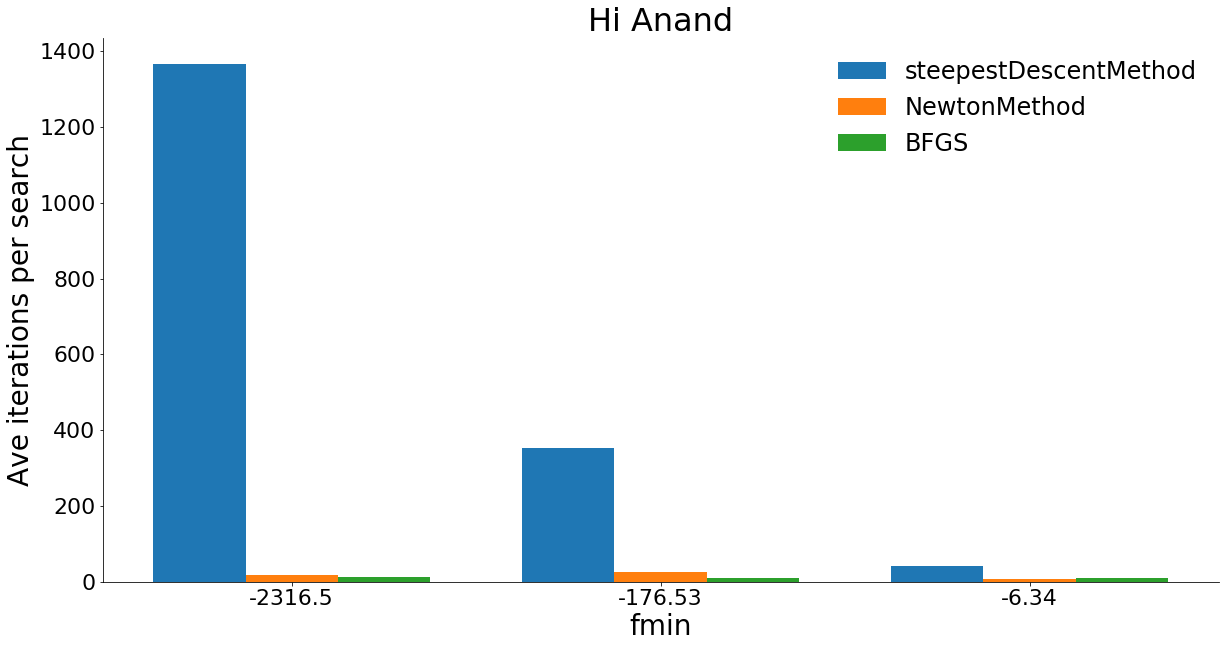

In [312]:
plot('fmin', 'iterations', 'Hi Anand')

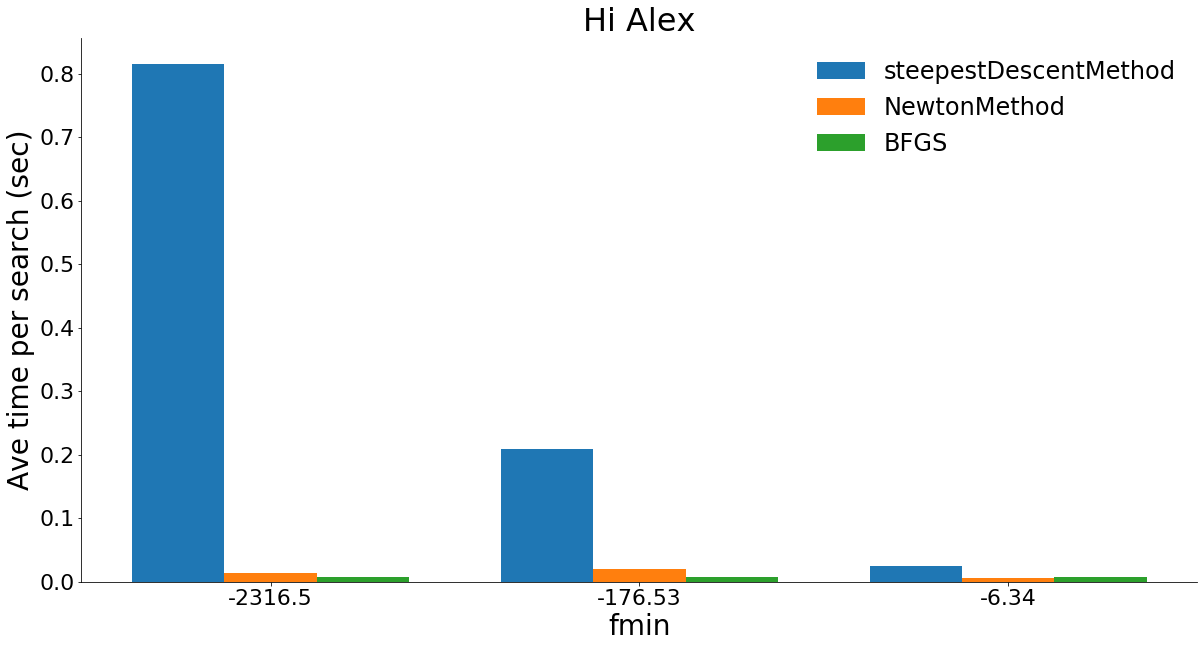

In [313]:
plot('fmin', 'time', 'Hi Alex')

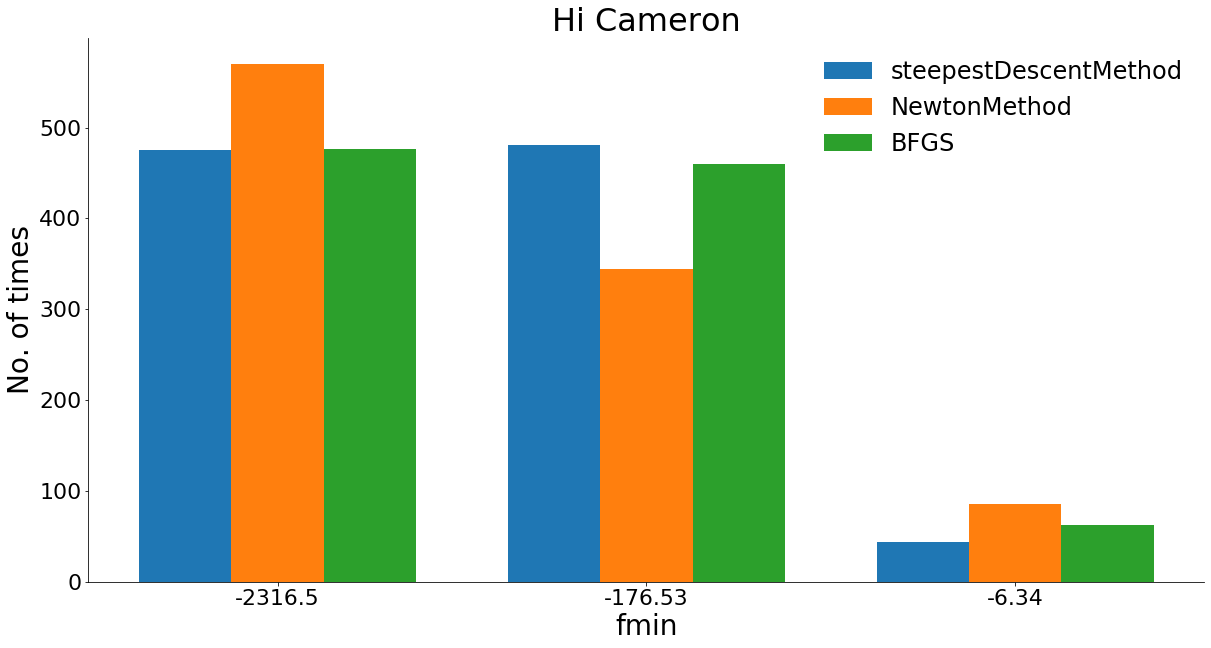

In [314]:
plot('fmin', 'count', 'Hi Cameron')